# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
from glob import glob
import time
import numpy as np
#import cv2
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 

HOME = os.path.expanduser("~")
# Root directory of the project
DATASET_DIR = HOME+'/.kaggle/competitions/data-science-bowl-2018/'
ROOT_DIR = HOME+'/projects/kaggle/data-science-bowl-2018/Mask_RCNN'

if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

from config import Config
import utils
import model as modellib
import visualize
from model import log

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/zack/anaconda3/envs/dev/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    #NUM_CLASSES = 1 + 3  # background + 3 shapes
    NUM_CLASSES = 1 + 1

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           shapes
NUM_CLASSES                    2
POOL_SIZE                      7


## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [5]:
from skimage.io import imread, imshow
from skimage.transform import resize

IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
TRAIN_IMAGE_PATH = glob(os.path.join(DATASET_DIR, 'train', '*'))
random.seed(768)
random.shuffle(TRAIN_IMAGE_PATH)

class MyDataset(utils.Dataset):
    def __init__(self, paths=None):
        super(self.__class__, self).__init__()
        self.add_class("data-science-bowl-2018", 1, "nuclei")
        self.images = []
        self.masks = []
        for idx, path in enumerate(paths):
            image_path = glob(os.path.join(path, 'images', '*.png'))[-1]
            img = imread(image_path)[:,:,:3]
            img = resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
            self.images.append(img)
            self.add_image(source='data-science-bowl-2018', image_id=idx, path=path)

            mask_paths = glob(os.path.join(path, 'masks', '*.png'))
            self.masks.append([])
            for mask_path in mask_paths:
                img = imread(mask_path)
                img = resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
                self.masks[-1].append(img)
            self.masks[-1] = np.stack(self.masks[-1], axis=-1)

    def load_image(self, image_id):
        return self.images[image_id]
    def load_mask(self, image_id):
        return self.masks[image_id], np.ones(self.masks[image_id].shape[-1], np.int32)
    def image_reference(self):
        return ''

dataset_train = MyDataset(TRAIN_IMAGE_PATH[:600])
dataset_val = MyDataset(TRAIN_IMAGE_PATH[600:])
dataset_train.prepare()
dataset_val.prepare()

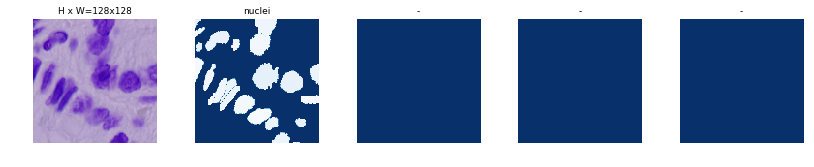

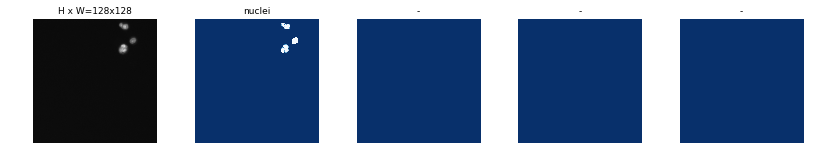

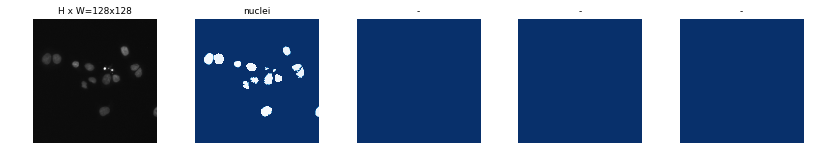

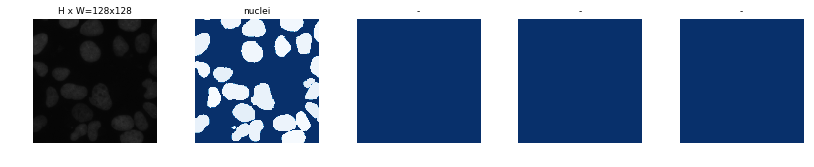

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/zack/projects/kaggle/data-science-bowl-2018/Mask_RCNN/logs/shapes20180331T0207/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_co

/home/zack/anaconda3/envs/dev/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/zack/anaconda3/envs/dev/lib/python3.6/site-packages/keras/engine/training.py:2095: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
100/100 [==============================] - 45s 446ms/step - loss: 3.2868 - rpn_class_loss: 0.4744 - rpn_bbox_loss: 1.2133 - mrcnn_class_loss: 0.3614 - mrcnn_bbox_loss: 0.6406 - mrcnn_mask_loss: 0.5971 - val_loss: 2.4869 - val_rpn_class_loss: 0.2356 - val_rpn_bbox_loss: 0.9928 - val_mrcnn_class_loss: 0.2522 - val_mrcnn_bbox_loss: 0.5351 - val_mrcnn_mask_loss: 0.4713


In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=200, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /home/zack/projects/kaggle/data-science-bowl-2018/Mask_RCNN/logs/shapes20180331T0207/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res

/home/zack/anaconda3/envs/dev/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/zack/anaconda3/envs/dev/lib/python3.6/site-packages/keras/engine/training.py:2095: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 2/200
100/100 [==============================] - 50s 504ms/step - loss: 2.4123 - rpn_class_loss: 0.2529 - rpn_bbox_loss: 0.9968 - mrcnn_class_loss: 0.2428 - mrcnn_bbox_loss: 0.4409 - mrcnn_mask_loss: 0.4790 - val_loss: 2.2914 - val_rpn_class_loss: 0.2195 - val_rpn_bbox_loss: 0.9526 - val_mrcnn_class_loss: 0.2300 - val_mrcnn_bbox_loss: 0.4248 - val_mrcnn_mask_loss: 0.4644
Epoch 3/200
100/100 [==============================] - 36s 361ms/step - loss: 2.3187 - rpn_class_loss: 0.2400 - rpn_bbox_loss: 0.9719 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.4116 - mrcnn_mask_loss: 0.4568 - val_loss: 2.2589 - val_rpn_class_loss: 0.2435 - val_rpn_bbox_loss: 0.8127 - val_mrcnn_class_loss: 0.2730 - val_mrcnn_bbox_loss: 0.4628 - val_mrcnn_mask_loss: 0.4670
Epoch 4/200
100/100 [==============================] - 36s 361ms/step - loss: 2.1538 - rpn_class_loss: 0.2121 - rpn_bbox_loss: 0.8782 - mrcnn_class_loss: 0.2231 - mrcnn_bbox_loss: 0.3949 - mrcnn_mask_loss: 0.4454 - val_loss: 2.1815 - val_rp

100/100 [==============================] - 36s 358ms/step - loss: 1.6894 - rpn_class_loss: 0.1536 - rpn_bbox_loss: 0.6764 - mrcnn_class_loss: 0.1819 - mrcnn_bbox_loss: 0.3037 - mrcnn_mask_loss: 0.3739 - val_loss: 1.6906 - val_rpn_class_loss: 0.1659 - val_rpn_bbox_loss: 0.7575 - val_mrcnn_class_loss: 0.1662 - val_mrcnn_bbox_loss: 0.2695 - val_mrcnn_mask_loss: 0.3314
Epoch 24/200
100/100 [==============================] - 35s 353ms/step - loss: 1.6629 - rpn_class_loss: 0.1474 - rpn_bbox_loss: 0.6564 - mrcnn_class_loss: 0.1805 - mrcnn_bbox_loss: 0.3020 - mrcnn_mask_loss: 0.3766 - val_loss: 1.6208 - val_rpn_class_loss: 0.1617 - val_rpn_bbox_loss: 0.6579 - val_mrcnn_class_loss: 0.1570 - val_mrcnn_bbox_loss: 0.2912 - val_mrcnn_mask_loss: 0.3531
Epoch 25/200
100/100 [==============================] - 36s 355ms/step - loss: 1.6277 - rpn_class_loss: 0.1504 - rpn_bbox_loss: 0.6543 - mrcnn_class_loss: 0.1756 - mrcnn_bbox_loss: 0.2874 - mrcnn_mask_loss: 0.3600 - val_loss: 1.6974 - val_rpn_class_lo

100/100 [==============================] - 35s 355ms/step - loss: 1.4683 - rpn_class_loss: 0.1291 - rpn_bbox_loss: 0.5625 - mrcnn_class_loss: 0.1676 - mrcnn_bbox_loss: 0.2651 - mrcnn_mask_loss: 0.3441 - val_loss: 1.4741 - val_rpn_class_loss: 0.1304 - val_rpn_bbox_loss: 0.5659 - val_mrcnn_class_loss: 0.1751 - val_mrcnn_bbox_loss: 0.2683 - val_mrcnn_mask_loss: 0.3343
Epoch 45/200
100/100 [==============================] - 35s 352ms/step - loss: 1.4429 - rpn_class_loss: 0.1239 - rpn_bbox_loss: 0.5607 - mrcnn_class_loss: 0.1675 - mrcnn_bbox_loss: 0.2550 - mrcnn_mask_loss: 0.3358 - val_loss: 1.6587 - val_rpn_class_loss: 0.1620 - val_rpn_bbox_loss: 0.6679 - val_mrcnn_class_loss: 0.1941 - val_mrcnn_bbox_loss: 0.2946 - val_mrcnn_mask_loss: 0.3401
Epoch 46/200
100/100 [==============================] - 35s 351ms/step - loss: 1.4527 - rpn_class_loss: 0.1304 - rpn_bbox_loss: 0.5645 - mrcnn_class_loss: 0.1669 - mrcnn_bbox_loss: 0.2555 - mrcnn_mask_loss: 0.3353 - val_loss: 1.4940 - val_rpn_class_lo

100/100 [==============================] - 35s 352ms/step - loss: 1.3118 - rpn_class_loss: 0.1120 - rpn_bbox_loss: 0.5009 - mrcnn_class_loss: 0.1505 - mrcnn_bbox_loss: 0.2301 - mrcnn_mask_loss: 0.3183 - val_loss: 1.7274 - val_rpn_class_loss: 0.1602 - val_rpn_bbox_loss: 0.6646 - val_mrcnn_class_loss: 0.2201 - val_mrcnn_bbox_loss: 0.3055 - val_mrcnn_mask_loss: 0.3770
Epoch 66/200
100/100 [==============================] - 35s 349ms/step - loss: 1.3195 - rpn_class_loss: 0.1147 - rpn_bbox_loss: 0.5070 - mrcnn_class_loss: 0.1538 - mrcnn_bbox_loss: 0.2285 - mrcnn_mask_loss: 0.3155 - val_loss: 1.3835 - val_rpn_class_loss: 0.1101 - val_rpn_bbox_loss: 0.5643 - val_mrcnn_class_loss: 0.1363 - val_mrcnn_bbox_loss: 0.2450 - val_mrcnn_mask_loss: 0.3278
Epoch 67/200
100/100 [==============================] - 36s 362ms/step - loss: 1.3557 - rpn_class_loss: 0.1179 - rpn_bbox_loss: 0.5135 - mrcnn_class_loss: 0.1584 - mrcnn_bbox_loss: 0.2379 - mrcnn_mask_loss: 0.3280 - val_loss: 1.5589 - val_rpn_class_lo

100/100 [==============================] - 37s 370ms/step - loss: 1.2505 - rpn_class_loss: 0.1064 - rpn_bbox_loss: 0.4779 - mrcnn_class_loss: 0.1475 - mrcnn_bbox_loss: 0.2153 - mrcnn_mask_loss: 0.3034 - val_loss: 1.3239 - val_rpn_class_loss: 0.1181 - val_rpn_bbox_loss: 0.4575 - val_mrcnn_class_loss: 0.1459 - val_mrcnn_bbox_loss: 0.2605 - val_mrcnn_mask_loss: 0.3419
Epoch 87/200
100/100 [==============================] - 36s 356ms/step - loss: 1.2792 - rpn_class_loss: 0.1090 - rpn_bbox_loss: 0.4881 - mrcnn_class_loss: 0.1489 - mrcnn_bbox_loss: 0.2198 - mrcnn_mask_loss: 0.3133 - val_loss: 1.3891 - val_rpn_class_loss: 0.1185 - val_rpn_bbox_loss: 0.5193 - val_mrcnn_class_loss: 0.1590 - val_mrcnn_bbox_loss: 0.2587 - val_mrcnn_mask_loss: 0.3336
Epoch 88/200
100/100 [==============================] - 35s 353ms/step - loss: 1.2053 - rpn_class_loss: 0.1026 - rpn_bbox_loss: 0.4604 - mrcnn_class_loss: 0.1372 - mrcnn_bbox_loss: 0.2081 - mrcnn_mask_loss: 0.2969 - val_loss: 1.2195 - val_rpn_class_lo

100/100 [==============================] - 35s 354ms/step - loss: 1.1583 - rpn_class_loss: 0.0942 - rpn_bbox_loss: 0.4436 - mrcnn_class_loss: 0.1314 - mrcnn_bbox_loss: 0.1948 - mrcnn_mask_loss: 0.2943 - val_loss: 1.4686 - val_rpn_class_loss: 0.1234 - val_rpn_bbox_loss: 0.5837 - val_mrcnn_class_loss: 0.1574 - val_mrcnn_bbox_loss: 0.2723 - val_mrcnn_mask_loss: 0.3318
Epoch 108/200
100/100 [==============================] - 36s 364ms/step - loss: 1.2138 - rpn_class_loss: 0.1031 - rpn_bbox_loss: 0.4672 - mrcnn_class_loss: 0.1375 - mrcnn_bbox_loss: 0.2045 - mrcnn_mask_loss: 0.3015 - val_loss: 1.4957 - val_rpn_class_loss: 0.1225 - val_rpn_bbox_loss: 0.6109 - val_mrcnn_class_loss: 0.1568 - val_mrcnn_bbox_loss: 0.2663 - val_mrcnn_mask_loss: 0.3392
Epoch 109/200
100/100 [==============================] - 36s 360ms/step - loss: 1.1711 - rpn_class_loss: 0.1002 - rpn_bbox_loss: 0.4504 - mrcnn_class_loss: 0.1284 - mrcnn_bbox_loss: 0.1985 - mrcnn_mask_loss: 0.2936 - val_loss: 1.3406 - val_rpn_class_

100/100 [==============================] - 36s 355ms/step - loss: 1.1488 - rpn_class_loss: 0.1011 - rpn_bbox_loss: 0.4311 - mrcnn_class_loss: 0.1322 - mrcnn_bbox_loss: 0.1931 - mrcnn_mask_loss: 0.2912 - val_loss: 1.2851 - val_rpn_class_loss: 0.1118 - val_rpn_bbox_loss: 0.5455 - val_mrcnn_class_loss: 0.1300 - val_mrcnn_bbox_loss: 0.2206 - val_mrcnn_mask_loss: 0.2771
Epoch 129/200
100/100 [==============================] - 35s 349ms/step - loss: 1.1342 - rpn_class_loss: 0.0944 - rpn_bbox_loss: 0.4212 - mrcnn_class_loss: 0.1257 - mrcnn_bbox_loss: 0.1983 - mrcnn_mask_loss: 0.2945 - val_loss: 1.4724 - val_rpn_class_loss: 0.1360 - val_rpn_bbox_loss: 0.5560 - val_mrcnn_class_loss: 0.2035 - val_mrcnn_bbox_loss: 0.2707 - val_mrcnn_mask_loss: 0.3061
Epoch 130/200
100/100 [==============================] - 35s 350ms/step - loss: 1.1014 - rpn_class_loss: 0.0907 - rpn_bbox_loss: 0.4201 - mrcnn_class_loss: 0.1241 - mrcnn_bbox_loss: 0.1865 - mrcnn_mask_loss: 0.2800 - val_loss: 1.2330 - val_rpn_class_

100/100 [==============================] - 35s 351ms/step - loss: 1.0727 - rpn_class_loss: 0.0894 - rpn_bbox_loss: 0.4083 - mrcnn_class_loss: 0.1187 - mrcnn_bbox_loss: 0.1781 - mrcnn_mask_loss: 0.2783 - val_loss: 1.4525 - val_rpn_class_loss: 0.1257 - val_rpn_bbox_loss: 0.5630 - val_mrcnn_class_loss: 0.1503 - val_mrcnn_bbox_loss: 0.2813 - val_mrcnn_mask_loss: 0.3322
Epoch 150/200
100/100 [==============================] - 35s 349ms/step - loss: 1.1005 - rpn_class_loss: 0.0945 - rpn_bbox_loss: 0.4117 - mrcnn_class_loss: 0.1266 - mrcnn_bbox_loss: 0.1847 - mrcnn_mask_loss: 0.2830 - val_loss: 1.2067 - val_rpn_class_loss: 0.1005 - val_rpn_bbox_loss: 0.4562 - val_mrcnn_class_loss: 0.1579 - val_mrcnn_bbox_loss: 0.2065 - val_mrcnn_mask_loss: 0.2856
Epoch 151/200
100/100 [==============================] - 35s 352ms/step - loss: 1.0961 - rpn_class_loss: 0.0965 - rpn_bbox_loss: 0.4124 - mrcnn_class_loss: 0.1263 - mrcnn_bbox_loss: 0.1815 - mrcnn_mask_loss: 0.2794 - val_loss: 1.2699 - val_rpn_class_

100/100 [==============================] - 37s 368ms/step - loss: 1.0426 - rpn_class_loss: 0.0877 - rpn_bbox_loss: 0.3905 - mrcnn_class_loss: 0.1192 - mrcnn_bbox_loss: 0.1736 - mrcnn_mask_loss: 0.2716 - val_loss: 1.3249 - val_rpn_class_loss: 0.1049 - val_rpn_bbox_loss: 0.5204 - val_mrcnn_class_loss: 0.1410 - val_mrcnn_bbox_loss: 0.2402 - val_mrcnn_mask_loss: 0.3185
Epoch 171/200
100/100 [==============================] - 36s 361ms/step - loss: 1.0560 - rpn_class_loss: 0.0905 - rpn_bbox_loss: 0.3962 - mrcnn_class_loss: 0.1231 - mrcnn_bbox_loss: 0.1743 - mrcnn_mask_loss: 0.2717 - val_loss: 1.2979 - val_rpn_class_loss: 0.1166 - val_rpn_bbox_loss: 0.5206 - val_mrcnn_class_loss: 0.1361 - val_mrcnn_bbox_loss: 0.2320 - val_mrcnn_mask_loss: 0.2926
Epoch 172/200
100/100 [==============================] - 37s 373ms/step - loss: 1.0965 - rpn_class_loss: 0.0942 - rpn_bbox_loss: 0.4148 - mrcnn_class_loss: 0.1255 - mrcnn_bbox_loss: 0.1803 - mrcnn_mask_loss: 0.2817 - val_loss: 1.4532 - val_rpn_class_

100/100 [==============================] - 39s 394ms/step - loss: 0.9779 - rpn_class_loss: 0.0805 - rpn_bbox_loss: 0.3610 - mrcnn_class_loss: 0.1107 - mrcnn_bbox_loss: 0.1636 - mrcnn_mask_loss: 0.2620 - val_loss: 1.2686 - val_rpn_class_loss: 0.0902 - val_rpn_bbox_loss: 0.5036 - val_mrcnn_class_loss: 0.1281 - val_mrcnn_bbox_loss: 0.2487 - val_mrcnn_mask_loss: 0.2981
Epoch 192/200
100/100 [==============================] - 36s 358ms/step - loss: 1.0256 - rpn_class_loss: 0.0881 - rpn_bbox_loss: 0.3872 - mrcnn_class_loss: 0.1157 - mrcnn_bbox_loss: 0.1662 - mrcnn_mask_loss: 0.2684 - val_loss: 1.1813 - val_rpn_class_loss: 0.0913 - val_rpn_bbox_loss: 0.5131 - val_mrcnn_class_loss: 0.1093 - val_mrcnn_bbox_loss: 0.2004 - val_mrcnn_mask_loss: 0.2671
Epoch 193/200
100/100 [==============================] - 35s 351ms/step - loss: 1.0239 - rpn_class_loss: 0.0843 - rpn_bbox_loss: 0.3784 - mrcnn_class_loss: 0.1170 - mrcnn_bbox_loss: 0.1736 - mrcnn_mask_loss: 0.2705 - val_loss: 1.4868 - val_rpn_class_

In [11]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [12]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/zack/projects/kaggle/data-science-bowl-2018/Mask_RCNN/logs/shapes20180331T0207/mask_rcnn_shapes_0200.h5


original_image           shape: (128, 128, 3)         min:    1.37500  max:  213.00000
image_meta               shape: (10,)                 min:    0.00000  max:  128.00000
gt_class_id              shape: (151,)                min:    1.00000  max:    1.00000
gt_bbox                  shape: (151, 4)              min:    0.00000  max:  128.00000
gt_mask                  shape: (128, 128, 151)       min:    0.00000  max:  255.00000


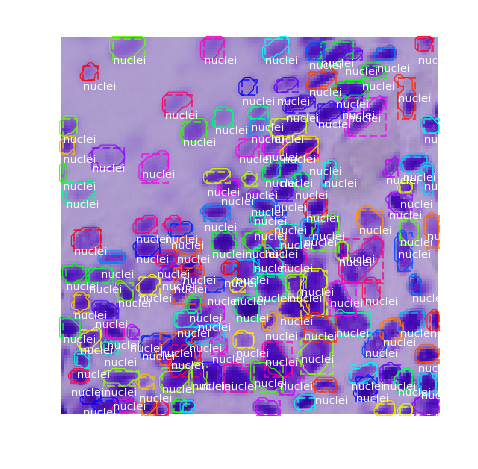

In [17]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:    1.37500  max:  213.00000
molded_images            shape: (1, 128, 128, 3)      min: -115.42500  max:  109.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  128.00000


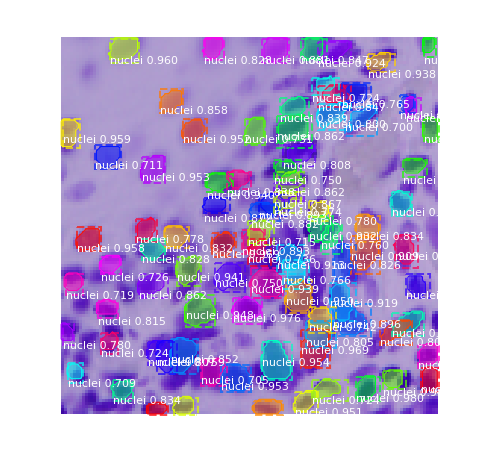

In [18]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [20]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 70)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.6964057084885528


In [160]:
key_pattern = re.compile(r'([a-z0-9]{64})')
TEST_IMAGE_PATH = glob(os.path.join(DATASET_DIR, 'test', '*'))
masks = {}
for path in TEST_IMAGE_PATH:
    key = key_pattern.findall(path)[-1]
    image_path = glob(os.path.join(path, 'images', key+'.png'))[-1]
    img = imread(image_path)[:,:,:3]
    original_shape = img.shape[:2]
    img = resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)

    results = model.detect([img])
    results = resize(results[0]['masks'], original_shape, mode='constant', preserve_range=True)
    masks[key] = [results[:,:,i:i+1]>0.5 for i in range(results.shape[-1])]
    total_mask = np.zeros(original_shape, dtype=bool)
    for i in range(len(masks[key])):
        masks[key][i] = np.reshape(masks[key][i], original_shape)
        intersection = masks[key][i] & total_mask
        masks[key][i] = masks[key][i] ^ intersection
        total_mask = masks[key][i] | total_mask

In [162]:
def rle_encoding(x):
    dots = np.where(x.T.flatten())[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev+1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths
keys = []
rles = []
for key in masks:
    rle = [rle_encoding(mask) for mask in masks[key]]
    rles.extend(rle)
    keys.extend([key] * len(rle))

In [158]:
def mask_to_label(mask):
    labels = []
    start = None
    count = 0
    for i in np.reshape(np.argwhere(np.reshape(mask.T, (-1,))>0), (-1,)):
        if start and start+count==i:
            count += 1
        elif start:
            labels.append([start+1, count])
            start, count = i, 1
        else:
            start, count = i, 1
    if start:
        labels.append([start+1, count])
    return [item for label in labels for item in label]
#rle_encoding(masks[key][0]), mask_to_label(masks[key][0]), masks[key][0].shape
#imshow(np.reshape(mask[:,:,0:1], mask.shape[:2]))
keys = []
rles = []
for key in masks:
    rle = [mask_to_label(mask) for mask in masks[key]]
    rle = [i for i in rle if i]
    rles.extend(rle)
    keys.extend([key] * len(rle))

In [159]:
import pandas as pd
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = keys
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv(HOME+'/projects/kaggle/data-science-bowl-2018/sub-dsbowl2018-1.csv', index=False)

In [148]:
masks[key][0].shape

(519, 253)